# Milestone 2 
# How much emission are you REALLY responsible for.

In this notebook we focus on exploring the dataset we have selected, and prepare the data for the story telling in milestone 3.

## Table of contents
1. [Introduction](#introduction)
    1. [Percentage of the worldly emission due to agriculture](#percentage_emissions)
    2. [Part of emission for meat/vegetal products](#world_meat_vegetal)
    3. [Emissions by Countries](#emissions_countries)
2. [Correcting emissions for Belgium and Switzerland](#correcting_emissions)
    1. [Belgium](#belgium_trade)
    2. [Switzerland](#swiss_trade)
    3. [Comparison between Belgium and Switzerland](#comparison_belgium_swiss_trade)


## Introduction <a name="introduction"></a>
In this section, we will present the data from a world-point of view, to get a feeling of what we're dealing with. This includes:
   - Visualising the percentage of emission due to agriculture
   - The part of emission in agriculture due to animal and vegetal products
   - The same as the previous point but by country.
   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# constants
DATA_PATH = '../data/'
GENERATED_DATA_PATH = '../generated/'

### Percentage of worldly emission due to agriculture <a name="percentage_emissions"></a>

In this section we will use the Environment_Emissions_by_Sector_E_All_Data_(Normalized) dataset. More information on this dataset can be found <a href="http://www.fao.org/faostat/en/#data/EM"> here </a>. 

Our goal is to get a global view on the situation, and see how an important factor agriculture has been over the years.


In [3]:
# Load data and drop unnecessary columns
emissions_sector_path = DATA_PATH+'Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv'
emissions_sector = pd.read_csv(emissions_sector_path, encoding='latin-1', engine='python')
emissions_sector.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,6814,"Energy (energy, manufacturing and construction...",7231,Emissions (CO2eq),1990,1990,Gigagrams,943.2945,A
1,2,Afghanistan,6814,"Energy (energy, manufacturing and construction...",7231,Emissions (CO2eq),1991,1991,Gigagrams,1022.1110,A
2,2,Afghanistan,6814,"Energy (energy, manufacturing and construction...",7231,Emissions (CO2eq),1992,1992,Gigagrams,542.7868,A
3,2,Afghanistan,6814,"Energy (energy, manufacturing and construction...",7231,Emissions (CO2eq),1993,1993,Gigagrams,548.8871,A
4,2,Afghanistan,6814,"Energy (energy, manufacturing and construction...",7231,Emissions (CO2eq),1994,1994,Gigagrams,537.9067,A


Emissions are expressed in <b>CO2eq units</b> (Carbon dioxide equivalent). CO2eq is a metric measure used to compare the emissions from various greenhouse gases on the basis of their global-warming potential (GWP), by converting amounts of other gases to the equivalent amount of carbon dioxide with the same global warming potential.

The <b>flags</b> represent the way the data is gathered (the full list can be found <a href="http://www.fao.org/faostat/en/#definitions"> here</a>).  

In [4]:
# Units
print(emissions_sector['Unit'].unique())
# Flags
emissions_sector.Flag.value_counts()

['Gigagrams' '%']


Fc    483973
A     336049
F        370
Name: Flag, dtype: int64

The flags represent : 
* `A` : Aggregate, may include official, semi-official, estimated or calculated data
* `Fc` : Calculated data
* `F` : FAO estimate

All these flag are acceptable, so we can then drop this column. From here on, we always implicitly check the flag values, but will not report it in this datastory (except if the flag represents unreliable data). 

Moreover, there is only one unit (Gigagrams), so we can drop this column aswell. 

In [5]:
# Drop unnecessary columns
emissions_sector.drop(columns=['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag', 'Unit'], inplace=True)

In [6]:
# elements that are sum of other elements (found in the data META-file)
aggregates = ["Energy total", "Land Use total", "Sources total","Sources total excl. AFOLU"]

In [7]:
# We want CO2eq emission over the world for the different sectors over the years
emissions_sector_world = emissions_sector.loc[(emissions_sector['Area']=="World") & (emissions_sector['Element'] == "Emissions (CO2eq)")]
emissions_sector_world = emissions_sector_world.drop(columns=["Element","Area"])

# Pivot to make items into columns and clean
emissions = pd.pivot_table(emissions_sector_world, columns='Item', index=["Year"])
emissions.columns = emissions.columns.droplevel(0)
# Drop the aggregate values
emissions = emissions.drop(columns=aggregates)

emissions.rename(columns={'Energy (energy, manufacturing and construction industries and fugitive emissions)':'Energy'}, inplace=True)

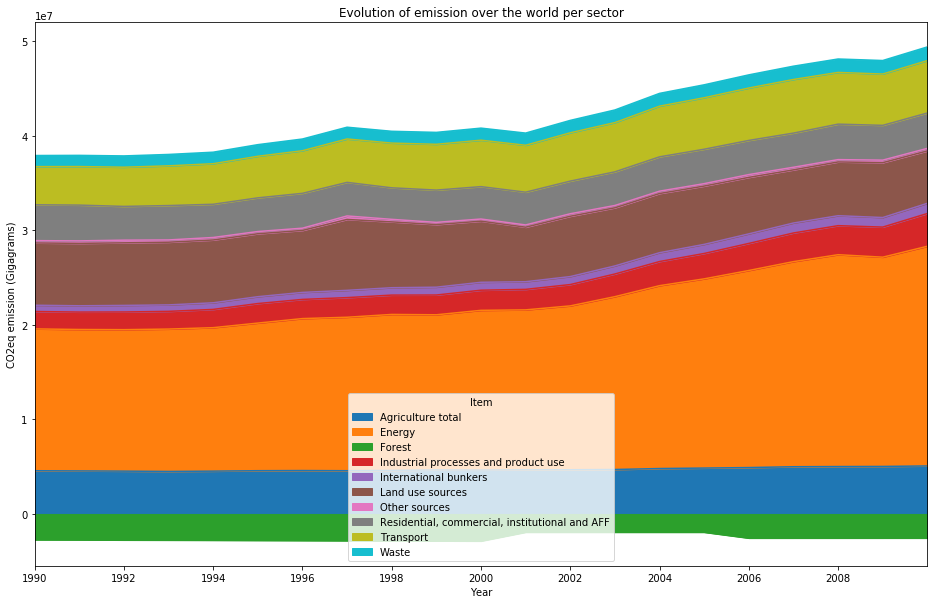

In [8]:
# Plot evolution of emission over the years
ax = emissions.plot.area()
fig = ax.get_figure()
fig.set_size_inches((16,10))
plt.title("Evolution of emission over the world per sector")
plt.ylabel("CO2eq emission (Gigagrams)")
ax.set_xticks(range(1990,2010,2))
plt.show()

As expected, we see that the worldy emission is rising (fast). Energy clearly makes up the biggest part, but agriculture also has a big influence.

Let's look at the percentages in 2010


In [144]:
emissions_sector_relative = emissions_sector.loc[(emissions_sector['Area'] == 'World') & (emissions_sector['Element'] == "Share of sector in total emissions") & (emissions_sector['Year'] == 2010)]
emissions_sector_relative = emissions_sector_relative.drop(columns=['Area', 'Element', 'Year']).sort_values(by='Value').round(2)
emissions_sector_relative

,Item,Value
696834,Other sources,0.54
697128,International bunkers,2.18
696540,Waste,2.93
696246,Industrial processes and product use,7.02
695952,"Residential, commercial, institutional and AFF",7.58
697422,Agriculture total,10.28
695658,Transport,11.22
697716,Land use sources,11.22
695364,"Energy (energy, manufacturing and construction...",47.04
698115,Energy total,65.84


Afolu means 'Agriculture, Forestry and Other Land Use' = 'Agriculture total' + 'Land use sources'

### Part of emissions for meat/vegetable <a name="world_meat_vegetal"></a>

Now that we know that agriculture makes up a remarkable part of greenhouse emissions, it is time to have a closes look. Many people give up eating meat for the climate, we will now investigate if this sacrifice is grounded. 

We will visualize the the part of emission in agriculture due to animal and vegetal products


In [106]:
# Load and clean data
emissions_total_path = DATA_PATH+'Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).csv'
emissions_total = pd.read_csv(emissions_total_path, encoding='latin-1', engine='python')
emissions_total = emissions_total.drop(columns=['Item Code', 'Element Code', 'Area Code', 'Year Code', 'Unit', 'Note', 'Flag'])

In [10]:
vegetal_emissions = ['Rice Cultivation', 'Synthetic Fertilizers', 'Manure applied to Soils', 'Crop Residues',
       'Cultivation of Organic Soils', 'Burning - Crop residues']
animal_emissions = ['Enteric Fermentation', 'Manure Management', 'Manure left on Pasture']

In [11]:
# We're only interested in the world data, and total emission
emissions_world = emissions_total.loc[(emissions_total['Area'] == 'World') & (emissions_total['Element'] == "Emissions (CO2eq)")]
emissions_world = emissions_world.drop(columns=['Area', 'Element'])

In [12]:
# Pivot the table to make element columns
emissions_world = pd.pivot_table(emissions_world, values='Value', index=['Year'], columns='Item')

In [13]:
# Let us have a quick look at the data
emissions_world

Item,Agricultural Soils,Agriculture total,Burning - Crop residues,Burning - Savanna,Crop Residues,Cultivation of Organic Soils,Enteric Fermentation,Manure Management,Manure applied to Soils,Manure left on Pasture,Rice Cultivation,Synthetic Fertilizers
Year,,,,,,,,,,,,
1961,7.423140e+05,2.751474e+06,20108.5834,NaN,84002.9553,NaN,1.372453e+06,250642.7499,127533.0080,4.559833e+05,365955.9325,74794.7749
1962,7.653188e+05,2.813011e+06,20233.7001,NaN,87863.9442,NaN,1.392502e+06,255847.4235,130164.1889,4.624951e+05,379109.0457,84795.5791
1963,7.836215e+05,2.849990e+06,20606.5104,NaN,88609.4599,NaN,1.407395e+06,258903.1345,131989.3153,4.677551e+05,379464.1001,95267.6498
1964,8.078094e+05,2.910094e+06,21119.8990,NaN,92894.6728,NaN,1.426616e+06,259543.8939,131372.4133,4.772082e+05,395004.9947,106334.1092
1965,8.379904e+05,2.971073e+06,21068.5649,NaN,92395.2622,NaN,1.453232e+06,264343.3867,134337.6366,4.879906e+05,394438.5363,123266.8707
1966,8.752929e+05,3.050038e+06,21435.8203,NaN,97648.0284,NaN,1.484941e+06,268016.1712,137986.2226,4.964990e+05,400351.9645,143159.6411
1967,9.054521e+05,3.121375e+06,21714.4552,NaN,100340.8951,NaN,1.514403e+06,275698.1244,141471.7620,5.073750e+05,404107.2079,156264.4185
1968,9.329120e+05,3.180822e+06,21870.0393,NaN,103423.8136,NaN,1.536975e+06,278263.7699,142494.8551,5.175750e+05,410800.6903,169418.3094
1969,9.526092e+05,3.211459e+06,21724.1911,NaN,103616.0835,NaN,1.544102e+06,277955.6862,142525.0221,5.226995e+05,415067.8733,183768.5941


We can see that our data contains NaN values for 'Burning Savanna' and 'Cultivation of Organic Soils'. Is this just in the world data, or is there no data available at all? 

In [14]:
print(emissions_total.loc[(emissions_total['Item'] == "Burning - Savanna")].Year.unique())
print(emissions_total.loc[(emissions_total['Item'] == "Cultivation of Organic Soils")].Year.unique())

[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2030 2050]
[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2030 2050]


There is no data available before 1990 (but we can assume that there was emission from these factors before that year. We will continue from the year 1990.

In [15]:
emissions_world = emissions_world[~emissions_world.isna().any(axis=1)]

In [16]:
%%capture
# Group by animal and vegetal
emissions_world['Animal'] = emissions_world[animal_emissions].sum(axis=1)
emissions_world['Vegetal'] = emissions_world[vegetal_emissions].sum(axis=1)
emissions_world = emissions_world[['Animal', 'Vegetal']]

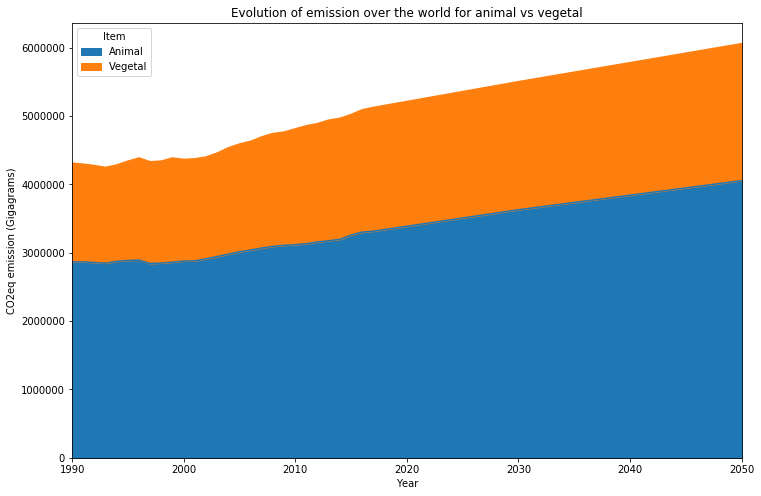

In [17]:
# Plot evolution of emission over the years (includes predictions for 2030 and 2050)
ax = emissions_world.plot.area()
fig = ax.get_figure()
fig.set_size_inches((12,8))
plt.title("Evolution of emission over the world for animal vs vegetal")
plt.ylabel("CO2eq emission (Gigagrams)")
plt.show()

We clearly see that Animal emission is a bigger influence than Vegetal emission (more than double). Moreover, we have not yet considered the fact that many vegetable products are used as fodder. 

Would humanity prosper by focussing more on vegetal products? The rest of our investigation will shed more light on this.

### Emission By countries <a name="emissions_countries"></a>

After studying the emissions in their globality we will focus on the emissions by countries.

In [107]:
# Filter only Emmisions (CO2eq)
print(emissions_total.shape)
emissions_total.head()

(517655, 5)


,Area,Item,Element,Year,Value
0,Afghanistan,Enteric Fermentation,Emissions (CH4),1961,240.6831
1,Afghanistan,Enteric Fermentation,Emissions (CH4),1962,245.3106
2,Afghanistan,Enteric Fermentation,Emissions (CH4),1963,255.8285
3,Afghanistan,Enteric Fermentation,Emissions (CH4),1964,259.0650
4,Afghanistan,Enteric Fermentation,Emissions (CH4),1965,265.5980


First, we have to investigate the countries to remove aggragated countries.

In [108]:
emissions_total.Area.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belgium-Luxembourg', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia (Plurinational State of)',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, mainland', 'China, Taiwan Province of', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire",
       'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Czechoslovakia',
       "Democratic People's Republic of Korea",
       'Democratic Re

In [109]:
# Remove aggregation item
agg_item = ['Agriculture total', 'Agricultural Soils']
emissions_total = emissions_total.drop(emissions_total[emissions_total['Item'].isin(agg_item)].index)

# Remove aggregation countries
# We remove China as we have different data for Hong kong, Tawain, Macao and the Mainland
agg_country = ['Belgium-Luxembourg', 'China', 'Yugoslav SFR','World', 'Africa',
       'Eastern Africa', 'Middle Africa', 'Northern Africa',
       'Southern Africa', 'Western Africa', 'Americas',
       'Northern America', 'Central America', 'Caribbean',
       'South America', 'Asia', 'Central Asia', 'Eastern Asia',
       'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Oceania', 'Australia and New Zealand',
       'Melanesia', 'Micronesia', 'Polynesia', 'European Union',
       'Least Developed Countries', 'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries', 'Annex I countries',
       'Non-Annex I countries', 'OECD']
emissions_total = emissions_total.drop(emissions_total[emissions_total['Area'].isin(agg_country)].index)
emissions_total = emissions_total.rename(columns={'Area':'Country'})

# Keep only past data
emissions_total = emissions_total[(emissions_total.Year < 2019)]

In [110]:
emissions_total

,Country,Item,Element,Year,Value
0,Afghanistan,Enteric Fermentation,Emissions (CH4),1961,240.6831
1,Afghanistan,Enteric Fermentation,Emissions (CH4),1962,245.3106
2,Afghanistan,Enteric Fermentation,Emissions (CH4),1963,255.8285
3,Afghanistan,Enteric Fermentation,Emissions (CH4),1964,259.0650
4,Afghanistan,Enteric Fermentation,Emissions (CH4),1965,265.5980
...,...,...,...,...,...
433705,Zimbabwe,Burning - Savanna,Emissions (N2O),2013,3.8549
433706,Zimbabwe,Burning - Savanna,Emissions (N2O),2014,4.2697
433707,Zimbabwe,Burning - Savanna,Emissions (N2O),2015,5.1211
433708,Zimbabwe,Burning - Savanna,Emissions (N2O),2016,3.0542


In [90]:
# In 2011, Sudan (former) split into two countries: Sudan and South Sudan. We will just assume one united Sudan and merge them.
emissions_total.loc[(emissions_total['Country']=='Sudan') & (emissions_total['Year']>2011), 'Value'] += emissions_total.loc[(emissions_total['Country']=='South Sudan') & (emissions_total['Year']>2011), 'Value'] 
emissions_total.loc[(emissions_total['Country']=='Sudan (former)', 'Country')] = 'Sudan'
emissions_total= emissions_total[emissions_total['Country'] != 'South Sudan']

Russia also poses a problem, as it only exists from 1992. Before, Russia and many other countries formed the USSR together.
As it is too complicated to split this up, we will just keep this data as original.

In [111]:
# Pivot the table to make element columns
emissions_total = pd.pivot_table(emissions_total, values='Value', index=['Country', 'Year'], columns='Item')
emissions_total.head()

Item              Burning - Crop residues  Burning - Savanna  Crop Residues  \
Country     Year                                                              
Afghanistan 1961                 48.14768                NaN     222.191933   
            1962                 49.56468                NaN     223.887467   
            1963                 49.56468                NaN     208.833033   
            1964                 49.95084                NaN     225.216933   
            1965                 49.82096                NaN     227.653600   

Item              Cultivation of Organic Soils  Enteric Fermentation  \
Country     Year                                                       
Afghanistan 1961                           NaN           3449.791633   
            1962                           NaN           3516.118733   
            1963                           NaN           3666.875433   
            1964                           NaN           3713.265000   
            1965                           NaN           3806.904667   

Item              Manure Management  Manure applied to Soils  \
Country     Year                                               
Afghanistan 1961          149.53680               260.714567   
            1962          153.04790               264.428667   
            1963          159.63620               271.603167   
            1964          162.58858               277.219600   
            1965          168.10418               285.631033   

Item              Manure left on Pasture  Rice Cultivation  \
Country     Year                                             
Afghanistan 1961             1581.328700        421.400000   
            1962             1553.267767        421.400000   
            1963             1596.084133        421.400000   
            1964             1617.861800        441.466667   
            1965             1657.354567        441.466667   

Item              Synthetic Fertilizers  
Country     Year                         
Afghanistan 1961                   4.31  
            1962                   4.31  
            1963                   4.31  
            1964                   4.31  
            1965                   4.31

In [112]:
# Here we assume that if there is no data the country just did not produce any emission of that type
emissions_total.fillna(0, inplace=True)

We will now divide the emissions between animal and vegetal emissions

In [113]:
emissions_total['Animal'] = emissions_total[animal_emissions].sum(axis=1)
emissions_total['Vegetal'] = emissions_total[vegetal_emissions].sum(axis=1)
emissions_total = emissions_total[['Animal', 'Vegetal']]

In [114]:
# Create a new column sum
emissions_total['Sum'] = emissions_total.sum(axis=1)
emissions_total.head()

Item                   Animal      Vegetal          Sum
Country     Year                                       
Afghanistan 1961  5180.657133   956.764180  6137.421313
            1962  5222.434400   963.590813  6186.025213
            1963  5422.595767   955.710880  6378.306647
            1964  5493.715380   998.164040  6491.879420
            1965  5632.363413  1008.882260  6641.245673

In [84]:
# create a new dataframe with relative numbers
relative_emissions_total = pd.DataFrame()
for col in emissions_total.columns:
    new_col = '% '+col
    relative_emissions_total[new_col] = emissions_total[col]/emissions_total['Sum'] * 100
    
relative_emissions_total.head()

% Animal  % Vegetal  % Sum
Country     Year                             
Afghanistan 1961  84.410974  15.589026  100.0
            1962  84.423102  15.576898  100.0
            1963  85.016229  14.983771  100.0
            1964  84.624421  15.375579  100.0
            1965  84.808840  15.191160  100.0

In [85]:
# Save the datasets for later use
emissions_total.to_csv(GENERATED_DATA_PATH+'emissions_total.csv')
relative_emissions_total.to_csv(GENERATED_DATA_PATH+'relative_emissions_total.csv')

#### EDA

We will now look at the descriptive statistics of the emission total data frame.

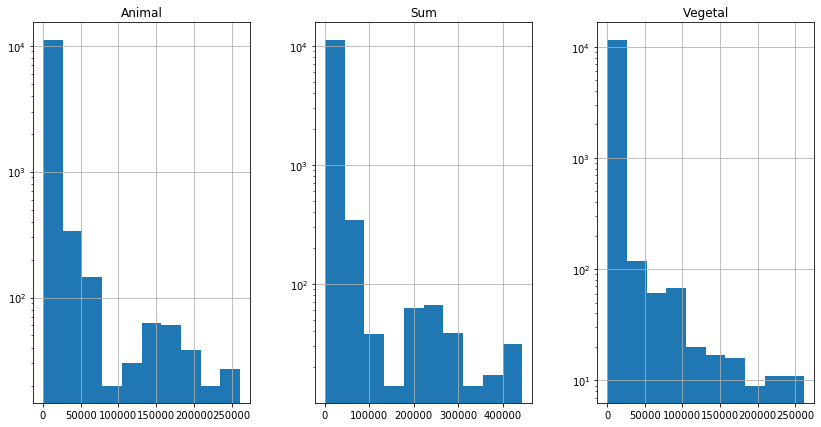

In [117]:
emissions_total.hist(figsize=(14,7), log=True, layout=(1,3))
plt.show()

The distribution seems to follow an exponential law. Indeed, if we look at the higher entry we see that it corresponds to the most populated country in the world (China) for the last years.

In [118]:
emissions_total['Sum'].sort_values(ascending=False).head(10)

Country          Year
China, mainland  2016    444373.463500
                 2015    442483.968093
                 2017    436156.198520
                 2014    435982.920227
                 2013    434647.288000
                 2012    432895.890900
                 2010    431570.527287
                 2011    431304.736207
                 1996    428703.425400
                 2009    425140.160640
Name: Sum, dtype: float64

To balance this bias introduced by the number of habitants we will divide all the emissions by the number of people to obtain the emission per capita.
The population information is available in the `Population_E_All_Data_(Normalized).csv` dataset.

In [124]:
population = pd.read_csv(DATA_PATH+'Population_E_All_Data_(Normalized).csv',  encoding='latin-1', engine='python')
print(population.shape)
population.head()

(160411, 12)


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1950,1950,1000 persons,7752.118,X,NaN
1,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1951,1951,1000 persons,7840.156,X,NaN
2,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1952,1952,1000 persons,7935.997,X,NaN
3,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1953,1953,1000 persons,8039.694,X,NaN
4,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1954,1954,1000 persons,8151.317,X,NaN


We need to clean the dataset

In [125]:
population = population[population['Element'] == 'Total Population - Both sexes']
population = population.drop(columns = ['Area Code', 'Item Code', 'Item', 'Element Code', 'Element', 'Year Code', 'Unit', 'Flag', 'Note'])
population = population.rename(columns={'Area':'Country', 'Value':'Population'})

# We also apply the transformation from Sudan (former) to Sudan 
population.loc[(population['Country']=='Sudan') & (population['Year']>2011), 'Population'] += population.loc[(population['Country']=='South Sudan') & (population['Year']>2011), 'Population'] 
population.loc[(population['Country']=='Sudan (former)', 'Country')] = 'Sudan'
population = population[population['Country'] != 'South Sudan']

#population.loc[population[population['Country'] == 'USSR'].index,'Country'] = 'Russian Federation'

# Set Country + Year as index
population = population.set_index(['Country', 'Year'])
print(population.shape)
# we have to multiply the value of popluation by 1000 because the unit was 1000 people
population['Population'] *= 1000
population.head()

(39352, 1)


Population
Country     Year            
Afghanistan 1950   7752118.0
            1951   7840156.0
            1952   7935997.0
            1953   8039694.0
            1954   8151317.0

In [126]:
# We can now make a join with the emission dataset
emissions_total_population = pd.merge(emissions_total, population, left_index=True, right_index=True).sort_index()
emissions_total_population.head()

Animal      Vegetal          Sum  Population
Country     Year                                                   
Afghanistan 1961  5180.657133   956.764180  6137.421313   9169410.0
            1962  5222.434400   963.590813  6186.025213   9351441.0
            1963  5422.595767   955.710880  6378.306647   9543205.0
            1964  5493.715380   998.164040  6491.879420   9744781.0
            1965  5632.363413  1008.882260  6641.245673   9956320.0

Finally we can devide the columns `Animal`, `Vegetal` and `Sum` by the population to obtain the emission per capita. We multiply by $$10^6$$ to receive the emission per capita in kilogram of CO2eq. 

In [127]:
emissions_per_capita = pd.DataFrame()
for col in ['Animal', 'Vegetal', 'Sum']:
    emissions_per_capita[col] = emissions_total_population[col] / emissions_total_population['Population'] * 1e6
emissions_per_capita.head()

Animal     Vegetal         Sum
Country     Year                                    
Afghanistan 1961  564.993509  104.343047  669.336556
            1962  558.463065  103.041960  661.505025
            1963  568.215371  100.145693  668.361064
            1964  563.759758  102.430628  666.190386
            1965  565.707351  101.330839  667.038190

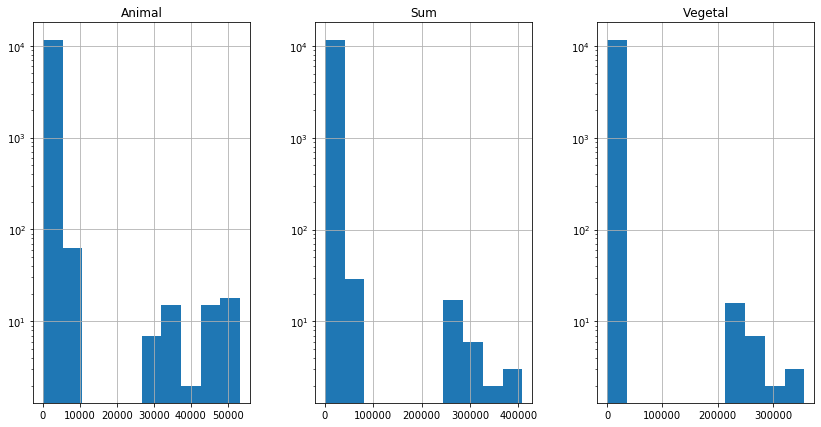

In [128]:
emissions_per_capita.hist(figsize=(14,7), log=True, layout=(1,3))
plt.show()

It seems to have outliers. Let's look at them. 

In [129]:
emissions_per_capita[emissions_per_capita['Animal'] > 40000]

Animal        Vegetal            Sum
Country                     Year                                            
Falkland Islands (Malvinas) 1961  43684.590781      88.225149   43772.815930
                            1962  43764.335224      88.327032   43852.662256
                            1963  45116.677730      88.904694   45205.582425
                            1964  45066.736943      90.001597   45156.738540
                            1965  45282.733397      91.033045   45373.766442
                            1966  45489.935212      92.500810   45582.436022
                            1967  46545.702574      94.261354   46639.963929
                            1968  46232.129309      94.425202   46326.554511
                            1969  46672.428476      95.093147   46767.521623
                            1970  47304.491299      95.431727   47399.923025
                            1971  48377.616862      96.294408   48473.911270
                            1972  48024.036791      95.230795   48119.267586
                            1973  46768.516598      96.109959   46864.626556
                            1974  47850.017325      96.067221   47946.084546
                            1975  49613.554037      97.127343   49710.681380
                            1976  49947.467796      97.494265   50044.962061
                            1977  49657.162138      98.437223   49755.599361
                            1978  50313.699947     115.038263   50428.738210
                            1979  50984.048772     132.365071   51116.413843
                            1980  51369.773463     141.477886   51511.251348
                            1981  50671.545684     159.263272   50830.808956
                            1982  51338.938820     167.677315   51506.616134
                            1983  51882.476915     181.386927   52063.863842
                            1984  52236.334417     195.287107   52431.621524
                            1985  53140.241441     198.558559   53338.800000
                            1986  53292.212040     191.931716   53484.143756
                            1987  51669.595149     163.813091   51833.408240
                            1988  51780.863741     156.953993   51937.817733
                            1989  53388.387766     149.092794   53537.480560
                            1990  51361.564077  356975.260679  408336.824756
                            1991  48447.261270  342954.968492  391402.229762
                            1992  45199.083333  327546.172840  372745.256173
                            1993  43313.637961  310845.093732  354158.731693
                            1994  41558.454025  296173.670992  337732.125017

In [130]:
emissions_total_population.loc['Falkland Islands (Malvinas)'].head()

,Animal,Vegetal,Sum,Population
Year,,,,
1961,92.873440,0.187567,93.061007,2126.0
1962,92.605333,0.186900,92.792233,2116.0
1963,95.151073,0.187500,95.338573,2109.0
1964,94.054280,0.187833,94.242113,2087.0
1965,94.097520,0.189167,94.286687,2078.0


We see that the outliers are caused by one country `Falkland Islands (Malvinas)`. The emission seems not so big on absolute, however, the island is only populated by 2000 people (the data contained in the dataset is correct, we have checked). Furthermore the island (which has the 5th highest Gross Product per Capita) is known for its industry of sheep farming. This explains that the emission coming from animals is the biggest one per capita. For now let us remove that country because even if the data is correct, we want to focus on larger countries and this particular case can be neglected.

In [131]:
emissions_per_capita = emissions_per_capita.drop(index='Falkland Islands (Malvinas)')

We will now take the mean of the emissions for each country over the years in order to see which are the ones that emit the most per capita.

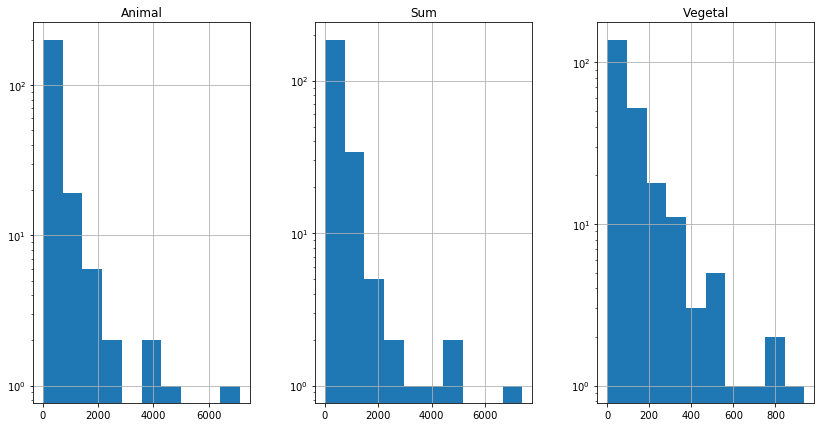

In [132]:
emissions_per_capita = emissions_per_capita.groupby(level=[0]).mean()
emissions_per_capita.hist(figsize=(14,7), log=True, layout=(1,3))
plt.show()

In [133]:
emissions_per_capita['Sum'].sort_values(ascending=False).head(10)

Country
New Zealand    7398.001096
Uruguay        4895.881623
Mongolia       4451.474875
Australia      4254.650018
Ireland        3270.815460
Paraguay       2346.861893
Argentina      2283.933067
Namibia        2065.345131
Somalia        1980.118501
Mauritania     1912.174699
Name: Sum, dtype: float64

In [134]:
emissions_per_capita['Animal'].sort_values(ascending=False).head(10)

Country
New Zealand    7143.584276
Uruguay        4610.856385
Australia      3975.826568
Mongolia       3677.255598
Ireland        2467.894539
Paraguay       2237.799988
Argentina      2126.091030
Namibia        2041.993702
Somalia        1958.589988
Mauritania     1870.103299
Name: Animal, dtype: float64

In [135]:
emissions_per_capita['Vegetal'].sort_values(ascending=False).head(10)

Country
Guyana       937.373270
Ireland      802.920921
Mongolia     774.219277
Belarus      706.612933
Suriname     653.400795
Cambodia     518.019752
Estonia      507.796001
Lithuania    507.333401
Thailand     494.949061
Denmark      483.404868
Name: Vegetal, dtype: float64

These country are not necessarily the ones we expected (that would be China or India).
This is because this dataset focusses on emission due to agriculture. Moreover we can see that the top 10 emitters are the same (almost in the same order) if we look at the total emsissions and the emsissions due to animal products. These countries are known for producing a lot of meat. It could be interesting to look at their emission when we consider the import and export.

## Correcting emissions for Belgium and Switzerland <a name="correcting_emissions"></a>
Then our main analysis will focus on comparing emission from Belgium and Switzerland for vegetable products and meat products.

The data presented in the introduction do not take into account the importation/exportation of the country.
We will use the `detailed trade matrix` data set to adapt these emission by adding emmission due to the production of imported procuct and removing emission for exportation product.

We will then compare these new data between belgium and Switzerland to figure out which country is responsible for the most emission.

First because the trade data set is huge we will only select rows concerning Belgium and then export the dataset to pandas to create a new csv file containing the rows we want.

In [145]:
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','4g'), # your
                                   ('spark.driver.maxResultSize', '2G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [149]:
trades = spark.read.csv(DATA_PATH+'Trade_DetailedTradeMatrix_E_All_Data_(Normalized).csv', header =True)

In [150]:
trades.printSchema()

root
 |-- Reporter Country Code: string (nullable = true)
 |-- Reporter Countries: string (nullable = true)
 |-- Partner Country Code: string (nullable = true)
 |-- Partner Countries: string (nullable = true)
 |-- Item Code: string (nullable = true)
 |-- Item: string (nullable = true)
 |-- Element Code: string (nullable = true)
 |-- Element: string (nullable = true)
 |-- Year Code: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Flag: string (nullable = true)



In [151]:
trades = trades.withColumnRenamed('Reporter Countries', 'Countries')

### Belgium <a name="belgium_trade"></a>

We will first study the trade of belgium

In [152]:
trades.registerTempTable("Trades")

query = """
SELECT *
FROM Trades
WHERE Countries = 'Belgium'
"""

belgium_trade = spark.sql(query)
belgium_trade.show(5)

+---------------------+---------+--------------------+-----------------+---------+---------------+------------+---------------+---------+----+--------+--------+----+
|Reporter Country Code|Countries|Partner Country Code|Partner Countries|Item Code|           Item|Element Code|        Element|Year Code|Year|    Unit|   Value|Flag|
+---------------------+---------+--------------------+-----------------+---------+---------------+------------+---------------+---------+----+--------+--------+----+
|                  255|  Belgium|                   2|      Afghanistan|      231|Almonds shelled|        5610|Import Quantity|     2015|2015|  tonnes|0.000000|null|
|                  255|  Belgium|                   2|      Afghanistan|      231|Almonds shelled|        5610|Import Quantity|     2016|2016|  tonnes|1.000000|null|
|                  255|  Belgium|                   2|      Afghanistan|      231|Almonds shelled|        5610|Import Quantity|     2017|2017|  tonnes|1.000000|null|
|   

In [153]:
belgium_trade_df = belgium_trade.toPandas()

In [154]:
belgium_trade_df.to_csv(GENERATED_DATA_PATH+'trade_belgium.csv')

From now we can begin with this cell.

In [155]:
belgium_trade_df = pd.read_csv(GENERATED_DATA_PATH+'trade_belgium.csv', index_col=0)

In [156]:
belgium_trade_df.head()

,Reporter Country Code,Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,255,Belgium,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2015,2015,tonnes,0.0,NaN
1,255,Belgium,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2016,2016,tonnes,1.0,NaN
2,255,Belgium,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2017,2017,tonnes,1.0,NaN
3,255,Belgium,2,Afghanistan,231,Almonds shelled,5622,Import Value,2015,2015,1000 US$,0.0,NaN
4,255,Belgium,2,Afghanistan,231,Almonds shelled,5622,Import Value,2016,2016,1000 US$,4.0,NaN


Get rid of useless columns and rename `Partner Countries`

In [157]:
belgium_trade_df = belgium_trade_df.drop(columns=['Reporter Country Code', 'Countries', 'Partner Country Code', 'Item Code', 'Element Code', 'Year Code', 'Unit', 'Flag'])
belgium_trade_df = belgium_trade_df.rename(columns={'Partner Countries': 'Country'})

In [158]:
belgium_trade_df.head()

,Country,Item,Element,Year,Value
0,Afghanistan,Almonds shelled,Import Quantity,2015,0.0
1,Afghanistan,Almonds shelled,Import Quantity,2016,1.0
2,Afghanistan,Almonds shelled,Import Quantity,2017,1.0
3,Afghanistan,Almonds shelled,Import Value,2015,0.0
4,Afghanistan,Almonds shelled,Import Value,2016,4.0


We will separate this dataset into 2 dataset : one for the trading of meat and animal product and the other for the vegetable products. The lists of animal items and vegetable item are in the `anim_items_trade.txt` and `veg_items_trade.txt` and have been done by hand.

In [159]:
animal_item = np.loadtxt(DATA_PATH+'anim_items_trade.txt', delimiter = '  ', dtype='str')

In [160]:
belgium_animal_trade = belgium_trade_df[belgium_trade_df.Item.isin(animal_item)]
belgium_animal_trade.head()

,Country,Item,Element,Year,Value
6,Afghanistan,"Animals, live, non-food",Export Value,2008,14.0
7,Afghanistan,"Animals, live, non-food",Export Value,2009,9.0
8,Afghanistan,"Animals, live, non-food",Export Value,2017,34.0
17,Afghanistan,Bacon and ham,Export Quantity,2005,0.0
18,Afghanistan,Bacon and ham,Export Quantity,2015,5.0


In [161]:
belgium_animal_trade = belgium_animal_trade.drop(columns='Item')

Get only the export quantity and import quantity

In [162]:
belgium_animal_trade.Element.unique()

array(['Export Value', 'Export Quantity', 'Import Quantity',
       'Import Value'], dtype=object)

In [163]:
belgium_animal_trade = belgium_animal_trade[belgium_animal_trade.Element.isin(['Export Quantity', 'Import Quantity'])]

In [164]:
# Pivot the table
belgium_animal_trade = pd.pivot_table(belgium_animal_trade, values='Value', index=['Country', 'Year'], columns='Element')
belgium_animal_trade.head()

Element           Export Quantity  Import Quantity
Country     Year                                  
Afghanistan 2003        22.000000              NaN
            2004         0.000000              NaN
            2005         1.166667              NaN
            2006        14.000000              NaN
            2007        25.000000              NaN

In [165]:
belgium_animal_trade.isnull().sum()[belgium_animal_trade.isnull().sum() != 0]

Element
Export Quantity      22
Import Quantity    1702
dtype: int64

We will fill the NaN value with 0 and consider the Belgium dif no import/export animal product the corresponding year from/to the country

In [166]:
belgium_animal_trade = belgium_animal_trade.fillna(value=0)

We will compute the net importation/exportation quantity between a country and belgium

In [167]:
belgium_animal_trade['Net Quantity'] = belgium_animal_trade['Import Quantity'] - belgium_animal_trade['Export Quantity']

We have information about ony the 21st century

In [168]:
belgium_animal_trade.index.levels[1]

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='Year')

But for some countries we do not have information about all year. We will just fill these years with 0's and consider that belgium didn't trade with these countries these years.

In [169]:
new_data = pd.DataFrame()
for col in belgium_animal_trade.columns:
    new_data[col] = belgium_animal_trade[col].unstack().fillna(value=0).stack()
belgium_animal_trade = new_data

In [170]:
belgium_animal_trade.head()

Export Quantity  Import Quantity  Net Quantity
Country     Year                                                
Afghanistan 2000              0.0              0.0           0.0
            2001              0.0              0.0           0.0
            2002              0.0              0.0           0.0
            2003             22.0              0.0         -22.0
            2004              0.0              0.0           0.0

We will do the same with the vegetable products

In [171]:
vegetable_item = np.loadtxt(DATA_PATH+'veg_items_trade.txt', delimiter = '  ', dtype='str')

def clean_trade_data(country_trade, item_list):
    # Keep animal or vegetable items
    trade = country_trade[country_trade.Item.isin(item_list)]
    trade = trade.drop(columns='Item')
    trade = trade[trade.Element.isin(['Export Quantity', 'Import Quantity'])]
    # Keep data from 2000 and after
    trade = trade[trade.Year >= 2000]
    # Pivot the table
    trade = pd.pivot_table(trade, values='Value', index=['Country', 'Year'], columns='Element')
    # Fill NaN
    trade.fillna(value=0, inplace=True)
    # Compute the Net Quantity
    trade['Net Quantity'] = trade['Import Quantity'] - trade['Export Quantity']
    # Fill the missing years with 0's
    new_data = pd.DataFrame()
    for col in trade.columns:
        new_data[col] = trade[col].unstack().fillna(value=0).stack()
    trade = new_data
    return trade

belgium_vegetable_trade = clean_trade_data(belgium_trade_df, vegetable_item)
belgium_vegetable_trade.head()

Export Quantity  Import Quantity  Net Quantity
Country     Year                                                
Afghanistan 2000          8154.50              0.0      -8154.50
            2001          1014.00              0.0      -1014.00
            2002           151.40              0.0       -151.40
            2003           373.00              0.0       -373.00
            2004           710.25              0.0       -710.25

We will now look at the evolution of the total net quantity traded by belgium from 2000 to 2017 for animal products and vegetable products.

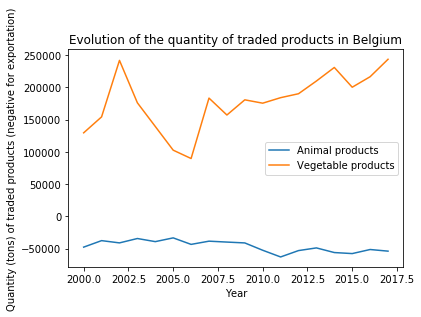

In [172]:
total_animal_product = belgium_animal_trade.groupby(level=1).sum()['Net Quantity']
total_vegetable_product = belgium_vegetable_trade.groupby(level=1).sum()['Net Quantity']

plt.plot(range(2000,2018), total_animal_product, label='Animal products')
plt.plot(range(2000,2018), total_vegetable_product, label='Vegetable products')
plt.title("Evolution of the quantity of traded products in Belgium")
plt.ylabel("Quantity (tons) of traded products (negative for exportation)")
plt.xlabel("Year")
plt.legend()
plt.show()

We can see that Belgium export more animal product than it import and that the quantity of exported animal product is relatively constant while Belgium imports much more vegetable products (one part of these vegetable product are used to feed the livestock). Moreover the importation of vegetable product has grown in the past few years.

### Switzerland <a name="swiss_trade"></a>

We will do the same job for switzerland
We first neeed to extract data related to switzerlad in the detailed trade matrix

In [173]:
trades.registerTempTable("Trades")

query = """
SELECT *
FROM Trades
WHERE Countries = 'Switzerland'
"""

swiss_trade = spark.sql(query)

In [174]:
swiss_trade_df = swiss_trade.toPandas()
swiss_trade_df.to_csv(GENERATED_DATA_PATH+'trade_switzerland.csv')

In [175]:
swiss_trade_df = pd.read_csv(GENERATED_DATA_PATH+'trade_switzerland.csv', index_col=0)
swiss_trade_df = swiss_trade_df.drop(columns=['Reporter Country Code', 'Countries', 'Partner Country Code', 'Item Code', 'Element Code', 'Year Code', 'Unit', 'Flag'])
swiss_trade_df = swiss_trade_df.rename(columns={'Partner Countries': 'Country'})

In [176]:
swiss_animal_trade = clean_trade_data(swiss_trade_df, animal_item)
swiss_vegetable_trade = clean_trade_data(swiss_trade_df, vegetable_item)

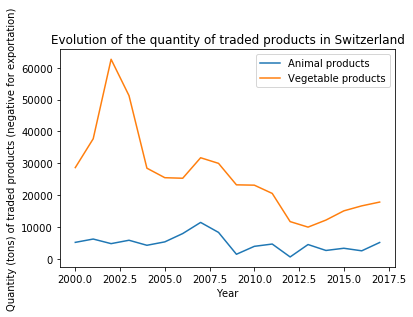

In [177]:
total_animal_product = swiss_animal_trade.groupby(level=1).sum()['Net Quantity']
total_vegetable_product = swiss_vegetable_trade.groupby(level=1).sum()['Net Quantity']

plt.plot(range(2000,2018), total_animal_product, label='Animal products')
plt.plot(range(2000,2018), total_vegetable_product, label='Vegetable products')
plt.title("Evolution of the quantity of traded products in Switzerland")
plt.ylabel("Quantity (tons) of traded products (negative for exportation)")
plt.xlabel("Year")
plt.legend()
plt.show()

We can see that switzerland import both animal and vegetable products. The importation of meat product is constant while the importation of vegetable product has decrease from 2002.

### Comparison between belgium and switzerland <a name="comparison_belgium_swiss_trade"></a>
The first comparison is made based on the quantity of importation for animal and vegetable products.

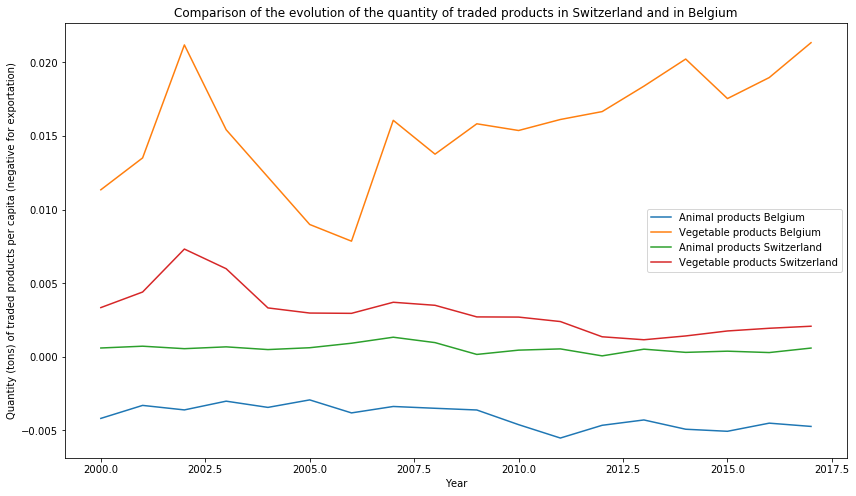

In [178]:
total_animal_product_belgium = []
total_vegetable_product_belgium = []
total_animal_product_switzerland = []
total_vegetable_product_switzerland = []

people_swiss = 8556000
people_belgium = 11400000

for year in range(2000, 2018):
    total_animal_product_belgium.append(belgium_animal_trade.xs(year, level=1)['Net Quantity'].sum()/people_belgium)
    total_vegetable_product_belgium.append(belgium_vegetable_trade.xs(year, level=1)['Net Quantity'].sum()/people_belgium)
    total_animal_product_switzerland.append(swiss_animal_trade.xs(year, level=1)['Net Quantity'].sum()/people_swiss)
    total_vegetable_product_switzerland.append(swiss_vegetable_trade.xs(year, level=1)['Net Quantity'].sum()/people_swiss)

plt.figure(figsize=(14,8))
plt.plot(range(2000,2018), total_animal_product_belgium, label='Animal products Belgium')
plt.plot(range(2000,2018), total_vegetable_product_belgium, label='Vegetable products Belgium')
plt.plot(range(2000,2018), total_animal_product_switzerland, label='Animal products Switzerland')
plt.plot(range(2000,2018), total_vegetable_product_switzerland, label='Vegetable products Switzerland')
plt.title("Comparison of the evolution of the quantity of traded products in Switzerland and in Belgium")
plt.ylabel("Quantity (tons) of traded products per capita (negative for exportation)")
plt.xlabel("Year")
plt.legend()
plt.show()

We can see that per capita, Belgium export more animal products but import much more vegetable product than Switzerland.

### Adding emissions <a name="adding_emissions"></a>
We will first compare direct emissions of the two countries. Then we will add the emission from the country where Belgium and Switzerland import their food. 

We will now join the emission dataframe with the dataframes created in the previous section

In [179]:
swiss_emission = emissions_total.loc['Switzerland']
swiss_emission = swiss_emission[swiss_emission.index >= 2000]
swiss_emission = swiss_emission[swiss_emission.index < 2018]

belgium_emission = emissions_total.loc['Belgium']
belgium_emission = belgium_emission[belgium_emission.index >= 2000]
belgium_emission = belgium_emission[belgium_emission.index < 2018]

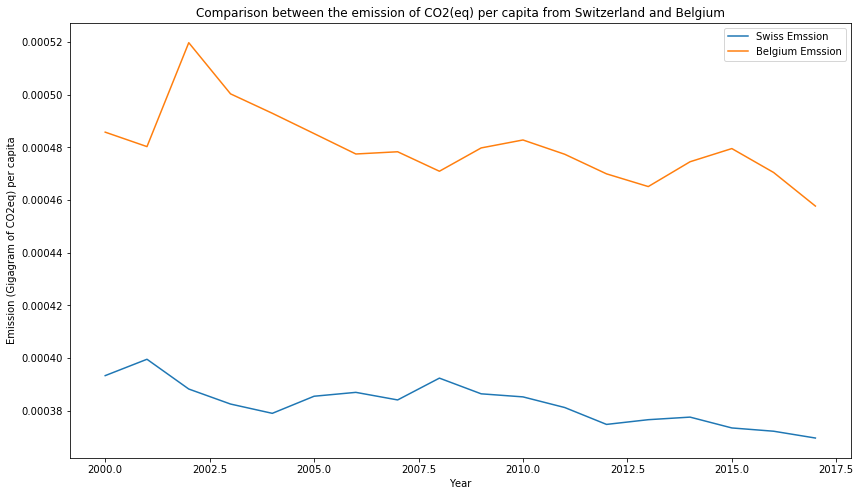

In [180]:
plt.figure(figsize=(14,8))
plt.plot(swiss_emission.index, swiss_emission.Sum/people_swiss, label='Swiss Emssion')
plt.plot(belgium_emission.index, belgium_emission.Sum/people_belgium, label='Belgium Emssion')
plt.title("Comparison between the emission of CO2(eq) per capita from Switzerland and Belgium")
plt.ylabel("Emission (Gigagram of CO2eq) per capita")
plt.xlabel("Year")
plt.legend()
plt.show()

We see that Belgium emits much more CO2eq per capita than Switerland. But it seems that both country try to reduce their emissions of CO2 eq.

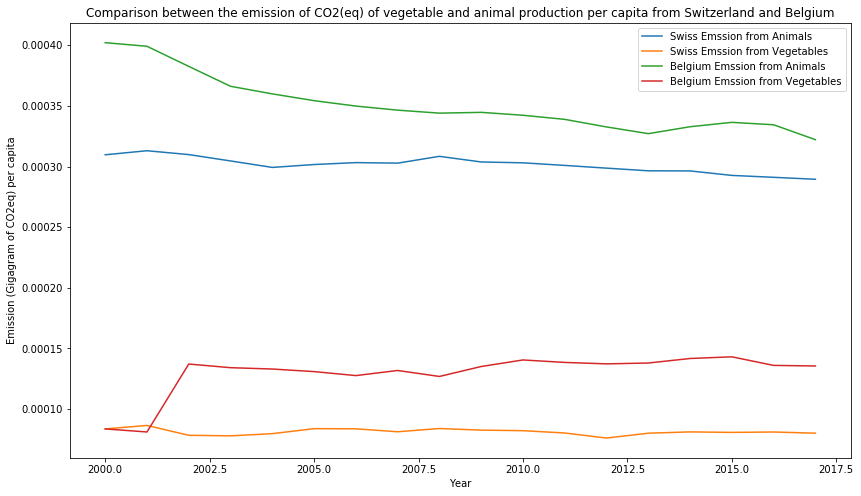

In [181]:
plt.figure(figsize=(14,8))
plt.plot(swiss_emission.index, swiss_emission.Animal/people_swiss, label='Swiss Emssion from Animals')
plt.plot(swiss_emission.index, swiss_emission.Vegetal/people_swiss, label='Swiss Emssion from Vegetables')
plt.plot(belgium_emission.index, belgium_emission.Animal/people_belgium, label='Belgium Emssion from Animals')
plt.plot(belgium_emission.index, belgium_emission.Vegetal/people_belgium, label='Belgium Emssion from Vegetables')
plt.title("Comparison between the emission of CO2(eq) of vegetable and animal production per capita from Switzerland and Belgium")
plt.ylabel("Emission (Gigagram of CO2eq) per capita")
plt.xlabel("Year")
plt.legend()
plt.show()

As seen before the majority of the emission is due to the production of animal product. Moreover the decreasing of the emission in total is due more by the reduction of emission of CO2eq from the production of animal products.

We now add the emission in the previously constructed datasets

In [182]:
def add_emissions(trade, emissions_total, local_emission):
    trade = pd.merge(trade, emissions_total['Animal'], left_index=True, right_index=True)
    trade = trade.rename(columns={'Animal':'Emission'})
    trade = pd.merge(trade, local_emission['Animal'], left_index=True, right_index=True)
    trade = trade.rename(columns={'Animal':'Local Emission'})
    return trade


belgium_animal_trade = add_emissions(belgium_animal_trade, emissions_total, belgium_emission)
belgium_vegetable_trade = add_emissions(belgium_vegetable_trade, emissions_total, belgium_emission)
swiss_animal_trade = add_emissions(swiss_animal_trade, emissions_total, swiss_emission)
swiss_vegetable_trade = add_emissions(swiss_vegetable_trade, emissions_total, swiss_emission)

In [183]:
belgium_animal_trade.to_csv(GENERATED_DATA_PATH+'belgium_animal_trade.csv')
belgium_vegetable_trade.to_csv(GENERATED_DATA_PATH+'belgium_vegetable_trade.csv')
swiss_animal_trade.to_csv(GENERATED_DATA_PATH+'swiss_animal_trade.csv')
swiss_vegetable_trade.to_csv(GENERATED_DATA_PATH+'swiss_vegetable_trade.csv')

### Production

We now add the information about production 

In [184]:
# Thomas you can add your code here instead of loading the data
production = pd.read_csv(GENERATED_DATA_PATH+'production_aggr.csv', encoding='latin-1')
production = production.drop(columns=['Unnamed: 0', 'Area Code'])
production = production.rename(columns={'Area':'Country'})
production = production[production['Year'] >= 2000]
production = production.set_index(['Country', 'Year'])
production.head()

Cereals     Roots   Sugar  Pulses   Nuts  Oilcrops  Vegetables  \
Country Year                                                                    
Armenia 2000  216970.0  290260.0   800.0  3863.0    0.0      12.0    372662.0   
        2001  360144.0  363834.0   800.0  3108.0    0.0      46.0    448573.0   
        2002  407583.0  374263.0   811.0  3368.0    0.0     267.0    463056.0   
        2003  305303.0  507518.0  1500.0  4710.0    0.0      86.0    569327.0   
        2004  451641.0  576427.0  6000.0  5234.0  330.0      52.0    600690.0   

                 Fruit  Spices  Stimulants      Milk     Eggs     Meat  
Country Year                                                            
Armenia 2000  368496.0     NaN         NaN  452100.0  21609.0  51321.0  
        2001  305323.0     NaN         NaN  465315.0  25114.0  48373.0  
        2002  299247.0     NaN         NaN  489548.0  26715.0  50256.0  
        2003  325506.0     NaN         NaN  513709.0  28157.0  52684.0  
        2004  411605.0     NaN         NaN  555240.0  31532.0  53456.0

In [185]:
vegetal_col = ['Cereals', 'Roots', 'Sugar', 'Pulses', 'Nuts', 'Oilcrops', 'Vegetables', 'Fruit', 'Spices', 'Stimulants']
animal_col = ['Milk', 'Eggs', 'Meat']
production_animal = pd.DataFrame(production[animal_col].sum(axis=1), columns=['Production'])
production_vegetal = pd.DataFrame(production[vegetal_col].sum(axis=1), columns=['Production'])
# We drop data for which the production is 0
production_animal = production_animal.drop(index=production_animal[production_animal['Production'] == 0].index)
production_vegetal = production_vegetal.drop(index=production_vegetal[production_vegetal['Production'] == 0].index)

In [186]:
belgium_animal_trade = pd.read_csv(GENERATED_DATA_PATH+'belgium_animal_trade.csv', index_col=[0,1])
belgium_vegetable_trade = pd.read_csv(GENERATED_DATA_PATH+'belgium_vegetable_trade.csv', index_col=[0,1])
swiss_animal_trade = pd.read_csv(GENERATED_DATA_PATH+'swiss_animal_trade.csv', index_col=[0,1])
swiss_vegetable_trade = pd.read_csv(GENERATED_DATA_PATH+'swiss_vegetable_trade.csv', index_col=[0,1])

In [187]:
def create_emissions_correction(trade, production, country):
    trade = pd.merge(trade, production, left_index=True, right_index=True).sort_index()
    local_production = production.loc[country]
    local_production = local_production.rename(columns={'Production' : 'Local Production'})
    trade = pd.merge(trade, local_production, left_index=True, right_index=True)
    trade['% of production'] = trade['Import Quantity'] / trade['Production']
    trade['% of local production'] = trade['Export Quantity'] / trade['Local Production']
    trade['Emission to add'] = trade['Emission'] * trade['% of production']
    trade['Emission to remove'] = trade['Local Emission'] * trade['% of local production']
    trade['Correction'] = trade['Emission to add'] - trade['Emission to remove']
    correction = trade.groupby(level=1).sum()['Correction']
    return correction

In [188]:
def correct_emissions(emissions, trade, production, country, product='Animal'):
    col_correction = product+' Correction'
    emissions[col_correction] = create_emissions_correction(trade, production, country)
    return emissions[product] + emissions[col_correction]    

In [189]:
belgium_emission_corrected = pd.DataFrame()
belgium_emission_corrected['Animal'] = correct_emissions(belgium_emission, belgium_animal_trade, production_animal, 'Belgium')
belgium_emission_corrected['Vegetal'] = correct_emissions(belgium_emission, belgium_vegetable_trade, production_vegetal, 'Belgium')
belgium_emission_corrected['Sum'] = belgium_emission_corrected['Animal'] + belgium_emission_corrected['Vegetal']

swiss_emission_corrected = pd.DataFrame()
swiss_emission_corrected['Animal'] = correct_emissions(swiss_emission, swiss_animal_trade, production_animal, 'Switzerland')
swiss_emission_corrected['Vegetal'] = correct_emissions(swiss_emission, swiss_vegetable_trade, production_vegetal, 'Switzerland')
swiss_emission_corrected['Sum'] = swiss_emission_corrected['Animal'] + swiss_emission_corrected['Vegetal']

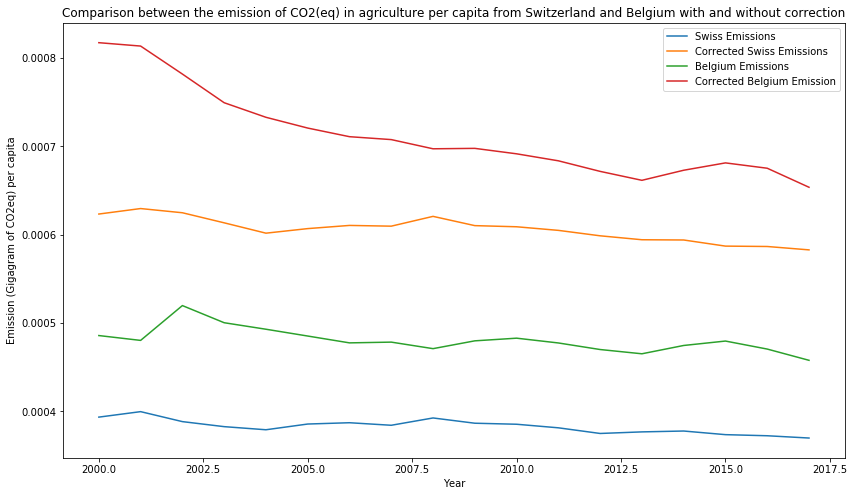

In [190]:
plt.figure(figsize=(14,8))
plt.plot(swiss_emission.index, swiss_emission.Sum/people_swiss, label='Swiss Emissions')
plt.plot(swiss_emission.index, swiss_emission_corrected.Sum/people_swiss, label='Corrected Swiss Emissions')
plt.plot(belgium_emission.index, belgium_emission.Sum/people_belgium, label='Belgium Emissions')
plt.plot(belgium_emission.index, belgium_emission_corrected.Sum/people_belgium, label='Corrected Belgium Emission')
plt.title("Comparison between the emission of CO2(eq) in agriculture per capita from Switzerland and Belgium with and without correction")
plt.ylabel("Emission (Gigagram of CO2eq) per capita")
plt.xlabel("Year")
plt.legend()
plt.show()